In [37]:
# import packages

import scipy.io as sio  # for loading matlab data

import numpy as np      # for numerical libs

from matplotlib.ticker import FuncFormatter # for custom bar plot labels

import matplotlib.pyplot as plt  # for plotting

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
from statsmodels.tsa import stattools
from statsmodels.graphics import gofplots
from scipy import stats
from statsmodels.tsa import arima_model
from statsmodels.regression import linear_model

# load data

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
data = sio.loadmat('/content/drive/MyDrive/MLinFinance/Project/MSFT_20141103.mat')

In [40]:
#data = sio.loadmat('MSFT_20141103.mat')
#data = sio.loadmat('MSFT_20141107.mat')
#data = sio.loadmat('GOOG_20141103.mat')

In [41]:
LOB=data['LOB']

t = (np.array((LOB['EventTime'][0][0][:,0]))-3600000*9.5)*1e-3      #time in seconds, measured from NASDAQ opening at 9:30am
bid = np.array(LOB['BuyPrice'][0][0]*1e-4)
bidvol = np.array(LOB['BuyVolume'][0][0]*1.0)
ask = np.array(LOB['SellPrice'][0][0]*1e-4)
askvol = np.array(LOB['SellVolume'][0][0]*1.0)
nMO = np.array(LOB['NumberMO'][0][0]*1.0)                           #total number of MOs submitted in the given 0.1 second interval
vMO = np.array(LOB['VolumeMO'][0][0]*1.0)                           #total volume of MOs submitted in the given 0.1 second interval
MO=np.array(LOB['MO'][0][0]*1.0)                                    #information about market orders
dt = t[1]-t[0]
print(dt)
print(t[0:10])
print(len(t))
print(bid[:,0])                                                     #best bid price over time
print(len(bid[:,0]))
print(t[-1])
tcur = 10*60*40

0.1
[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
234000
[46.73 46.75 46.8  ... 47.43 47.43 47.43]
234000
23400.0


In [42]:
#print(bid)
#print(len(bid[0,:]))
#print(len(bidvol[0,:]))
#print(len(ask[0,:]))
#print(len(askvol[0,:]))
#print(len(nMO[0,:]))
#print(len(vMO[0,:]))
#print(len(MO[0,:]))
#print(nMO)
#print(len(MO[:,0]))
print(MO[0,4])

32.0


# Microprice

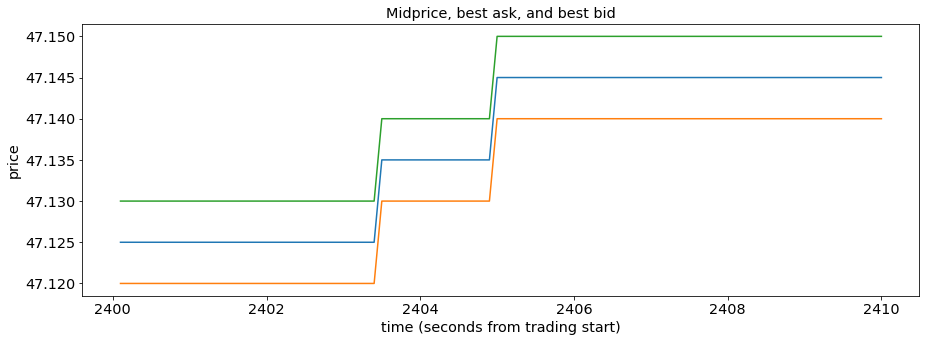

In [43]:
#plot midprice and best bid/ask prices
midprice = 0.5*(bid[:,0]+ask[:,0])
spread = ask[:,0]-bid[:,0]
plt.plot(t[tcur:(tcur+100)],midprice[tcur:(tcur+100)])
plt.plot(t[tcur:(tcur+100)],bid[tcur:(tcur+100),0])
plt.plot(t[tcur:(tcur+100)],ask[tcur:(tcur+100),0])
plt.title('Midprice, best ask, and best bid')
plt.ylabel('price')
plt.xlabel('time (seconds from trading start)')
plt.show()

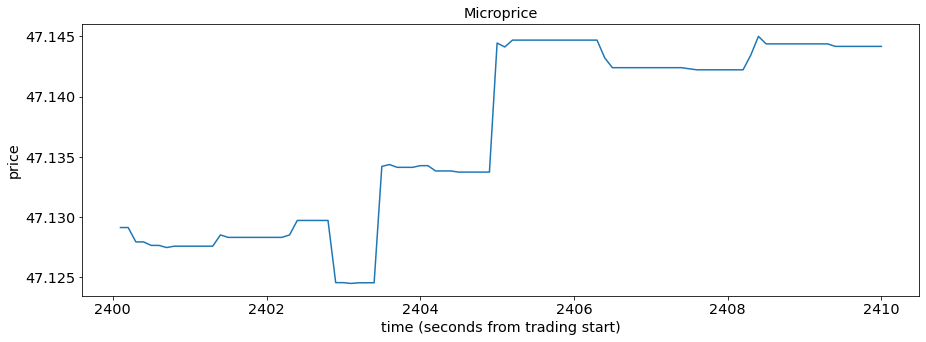

In [44]:
#plot microprice
microprice= (bid[:,0]*askvol[:,0]+ask[:,0]*bidvol[:,0])/(bidvol[:,0]+askvol[:,0])
plt.plot(t[tcur:(tcur+100)], microprice[tcur:(tcur+100)])
plt.title('Microprice')
plt.ylabel('price')
plt.xlabel('time (seconds from trading start)')
plt.show()


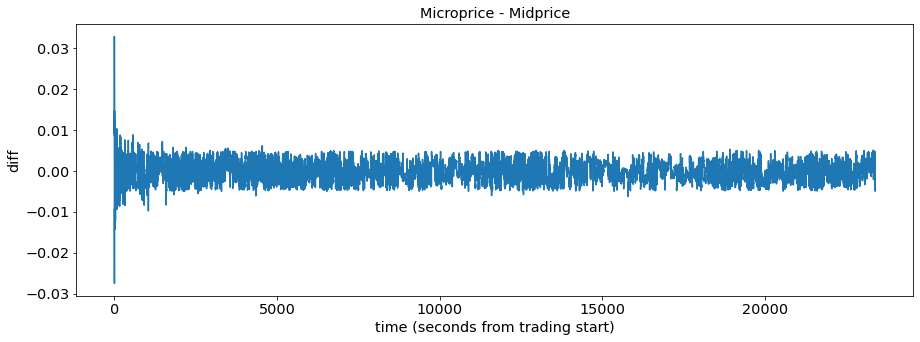

In [45]:
# microprice is almost always different from midprice
plt.plot(t, microprice-midprice)
plt.title('Microprice - Midprice')
plt.ylabel('diff')
plt.xlabel('time (seconds from trading start)')
plt.show()

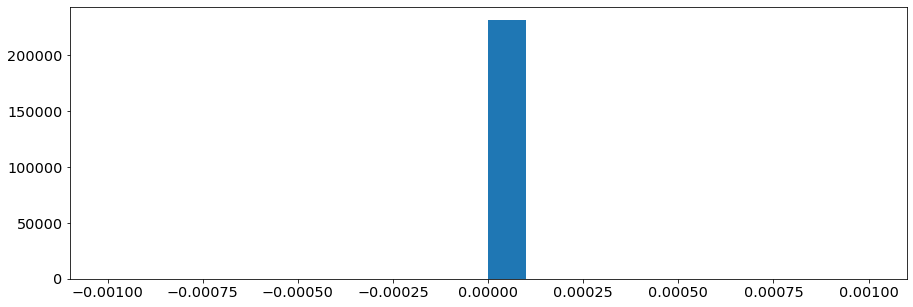

In [46]:
#midprice takes values {$0,+-$0.01}
plt.hist(np.diff(midprice),20,(-0.001,0.001));

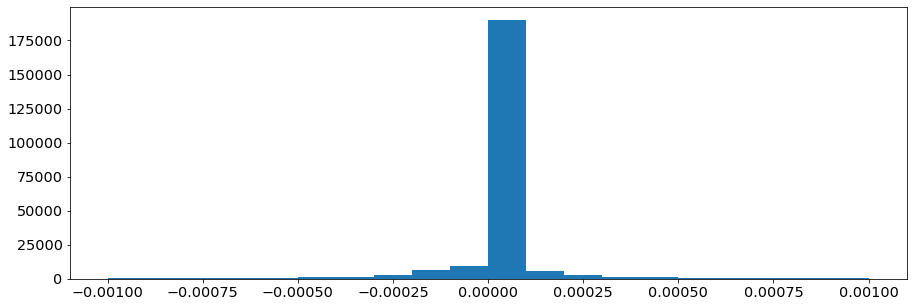

In [47]:
#microprice takes a large number of possible values
plt.hist(np.diff(microprice),20,(-0.001,0.001));

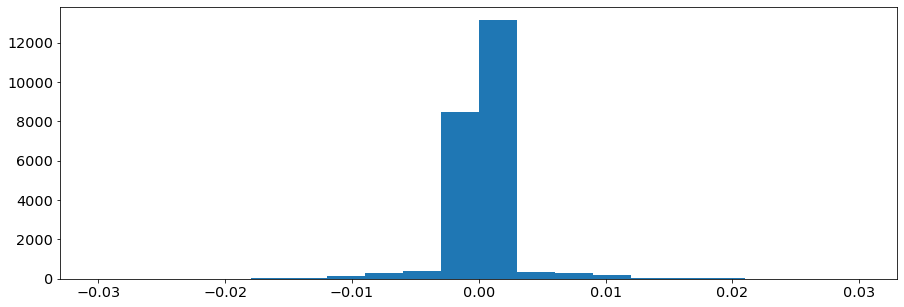

In [48]:
#increments of microprice over 1 second look closer to normal distribution
ret_1sec = np.diff(microprice[::10])
plt.hist(ret_1sec,20,(-0.03,0.03));

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


[ 1.00000000e+00 -4.14975982e-03 -8.64549118e-03 -2.01190382e-02
 -2.54129421e-02  6.63126282e-04 -2.23292520e-02  8.68953216e-03
  1.40518934e-02  1.33387131e-02  1.72884355e-02 -1.49138585e-03
 -7.40690493e-03 -2.35259194e-05 -4.94415982e-03  6.13786195e-04
 -9.93715597e-03  4.33624068e-04  3.81628551e-03  3.97236654e-03]


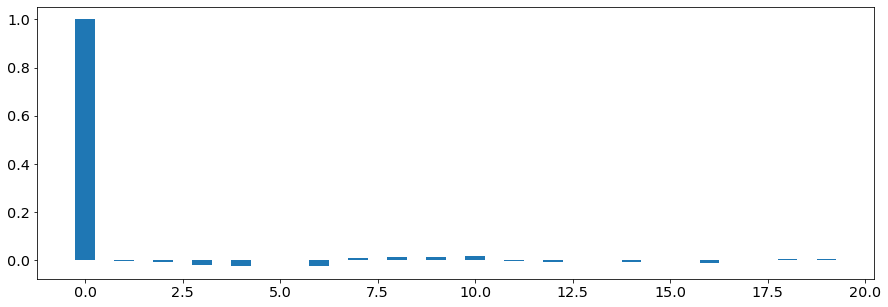

In [49]:
#increments of microprice look like WN
ret = np.diff(microprice)
my_acf = stattools.acf(ret);
plt.bar(range(20), my_acf[0:20],width=0.5)#autocorrelation of microprice returns over 100ms
print(my_acf[0:20])

# U-shaped intraday traded volume rate

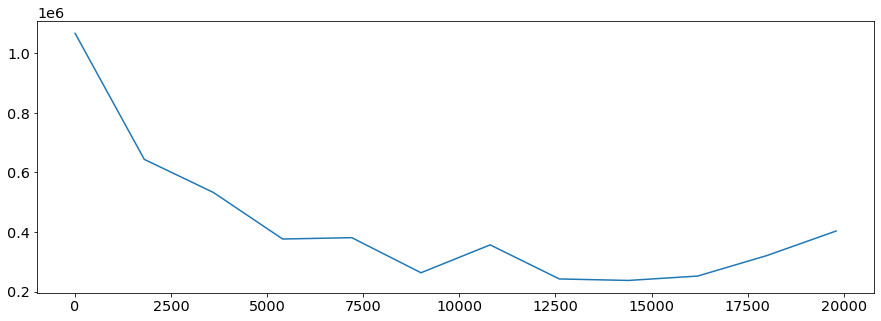

In [50]:
#plot the speed of traded volume assuming it is constant over time buckets of size 30 min
bucketsize = 10*60*30 #size of a time bucket
tradedV = []
for i in range(int(len(t)/bucketsize-1)):
    tradedV.append(np.sum(vMO[(i*bucketsize):((i+1)*bucketsize),0]+vMO[(i*bucketsize):((i+1)*bucketsize),0]))
    #tradedV.append(vMO[(i*bucketsize):((i+1)*bucketsize),0])
plt.plot([t[i*bucketsize] for i in range(len(tradedV))],tradedV)

# Order flow

234000
[   3138.   11849.   10366. ... -461685. -462885. -462885.]
[ 100. 2386. 3100.  100.  200. 2000.  200. 2000.  100. 2000. 2000. 3000.
  100.  100.  100.  100.  300.   75.  100.  100.]


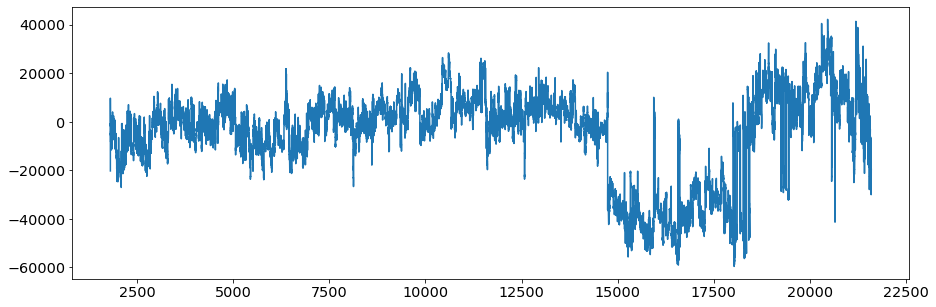

In [51]:
#order flow as a function of time
OF = np.sum(bidvol[:,:10],axis=1)-np.sum(askvol[:,:10],axis=1)
print(len(OF))
print(OF)
print(bidvol[0,:])
ind1=10*60*30
ind2=10*60*(30+11*30)
plt.plot(t[ind1:ind2],OF[ind1:ind2])

0.0011165571360695994
0.9348985730335301


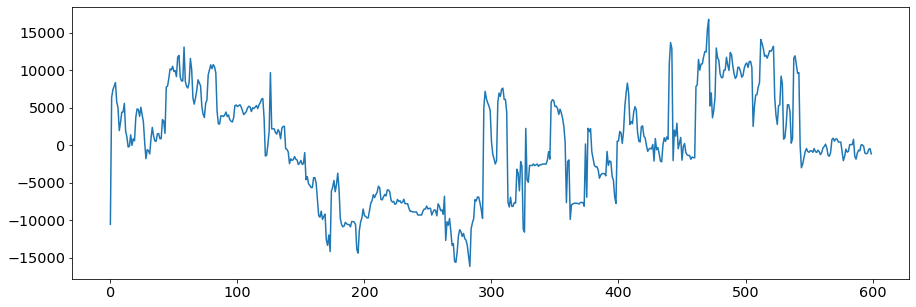

In [83]:
#run DF test on the centered OF
ind3=10*60*(30+10)
OF1 = OF[ind1:ind3]
OF1_centered = OF1-np.mean(OF1)
freq = 10
plt.plot(OF1_centered[::freq])
my_DF = stattools.adfuller(OF1_centered[::freq],1,'c',None)
print(my_DF[1])#pvalue
phi, sigma = linear_model.yule_walker(OF1_centered[::freq],order=1)
print(phi[0])

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


[1.         0.99106847 0.98370819 0.9772373  0.97075815 0.96486912
 0.95897624 0.9526615  0.94643089 0.94049469 0.93444111 0.92831003
 0.92245013 0.91729474 0.91234778 0.90748684 0.90299439 0.89863728
 0.89414096 0.8897341 ]


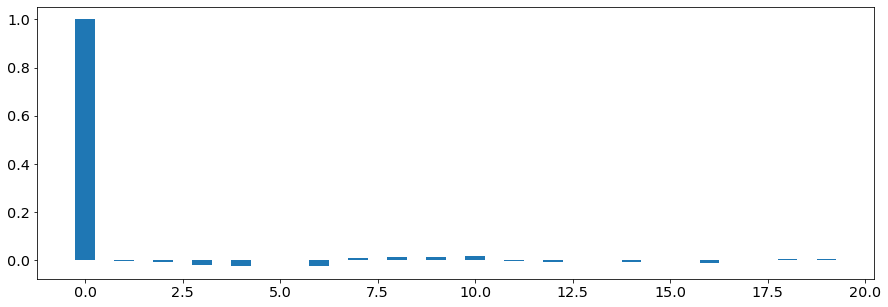

In [53]:
acf_OF = stattools.acf(OF1_centered);
plt.bar(range(20), my_acf[0:20],width=0.5)#autocorrelation of microprice returns over 100ms
print(acf_OF[0:20])

# Predicting future OF

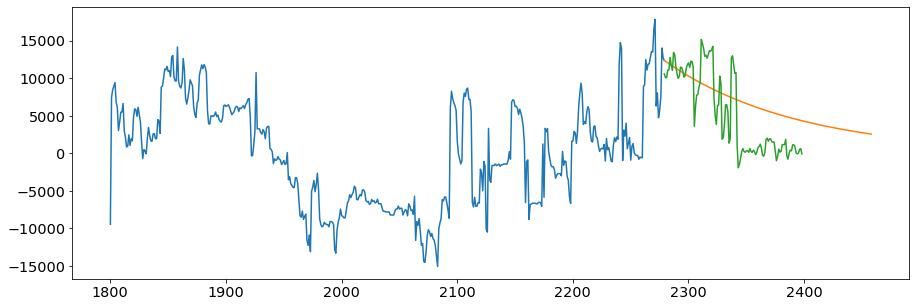

In [54]:
#test the prediction of OF: blue line is the past and present OF,
#orange line is the trend fitted to past and present values of OF,
#red line is the future OF,
#green line is the prediction (i.e. expected value) of future OF

ind4=10*60*(30+8)
OF2 = OF[ind1:ind4]
mu = np.mean(OF2)
OF2_centered = OF2-mu
freq = 10
OF3 = OF2_centered[::freq]
t1 = t[ind1:ind4]
t2 = t1[::freq]
h = range(60*3)#predictions times, in seconds from t2[-1]
OF_pred = [OF3[-1] - OF3[-1]*(1-phi[0]**h[i]) for i in range(len(h))]
plt.plot(t2,OF3)
plt.plot([h[i]+t2[-1] for i in range(len(h))],OF_pred)
OF4 = OF[ind4:ind3:freq] - mu
plt.plot([h[i]+t2[-1] for i in range(len(OF4))],OF4)

# Price impact

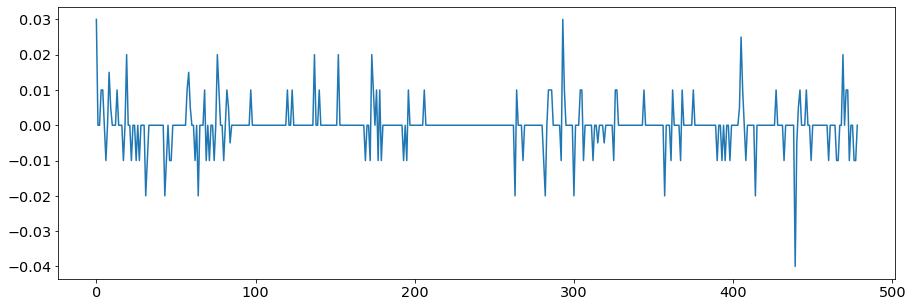

In [55]:
#compute midprice, its increments (with reduced frequency), and the increments of OF
price = midprice[ind1:ind4]
price_inc = np.diff(price[::freq])
OF_inc = np.diff(OF3)
plt.plot(price_inc)

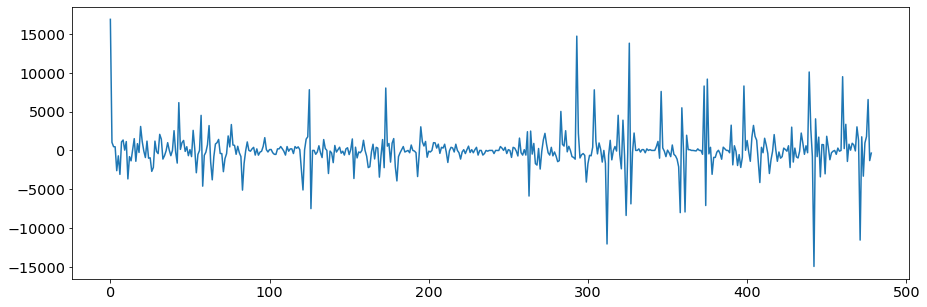

In [56]:
plt.plot(OF_inc)

4.1396736075891987e-07
0.000125949180806188
0.03038180802555406
-6.0627626704837535e-05


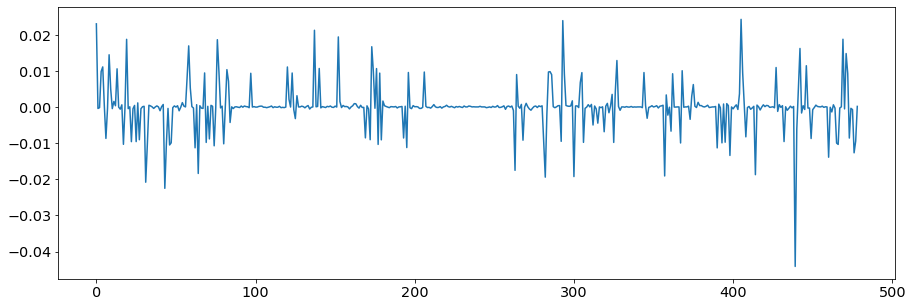

In [57]:
#regress the increments of price on the increments of OF
slope, intercept, r_value, p_value, std_err = stats.linregress(OF_inc,price_inc)
print(slope)
print(p_value)
print(r_value**2)
print(intercept)
res = [price_inc[i] - slope*OF_inc[i] - intercept for i in range(len(price_inc))]
plt.plot(res)

Text(0, 0.5, 'Midprice')

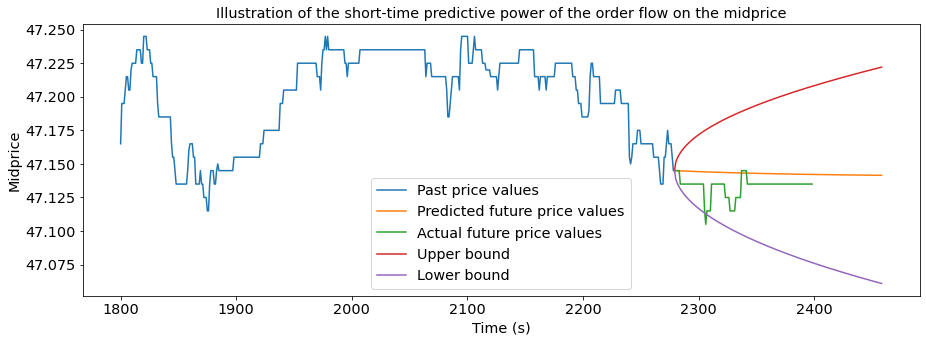

In [58]:
#plot the past and present pric values (blue), predicted future price values (green),
#actual future price values (orange), and the 1-std-deviation bounds around the prediction
h = range(60*3)
price2 = price[::10]
plt.plot(t2,price2,label='Past price values')
P_pred = [price2[-1] - (OF2_centered[-1]*(1-phi[0]**h[i]))*slope for i in range(len(h))]
plt.plot([h[i]+t2[-1] for i in range(len(h))],P_pred,label='Predicted future price values')

price3 = midprice[ind4:ind3:freq]
plt.plot([h[i]+t2[-1] for i in range(len(price3))],price3,label='Actual future price values')

sigma_hat = np.std(res)
upper_bd = [P_pred[i] + (h[i]**0.5)*sigma_hat for i in range(len(h))]
plt.plot([h[i]+t2[-1] for i in range(len(h))],upper_bd,label='Upper bound')
lower_bd = [P_pred[i] - (h[i]**0.5)*sigma_hat for i in range(len(h))]
plt.plot([h[i]+t2[-1] for i in range(len(h))],lower_bd, label='Lower bound')

plt.legend(loc="lower center")
plt.title('Illustration of the short-time predictive power of the order flow on the midprice')
plt.xlabel('Time (s)')
plt.ylabel('Midprice')

## **MICROPRICE** **WORK**

In [59]:
#plot microprice
microprice = (bid[:,0]*askvol[:,0]+ask[:,0]*bidvol[:,0])/(bidvol[:,0]+askvol[:,0])

In [60]:
#compute LO imbalance for each time stamp
rho = np.array((bidvol[:,0]-askvol[:,0])/(bidvol[:,0]+askvol[:,0]),ndmin=2).T

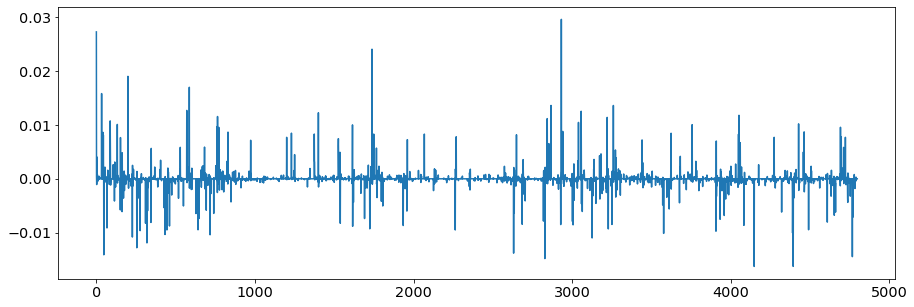

In [61]:
#compute microprice, its increments, and the increments of OF
microprice_idx = microprice[ind1:ind4]
microprice_inc = np.diff(microprice_idx)
OF_inc = np.diff(OF2_centered)
plt.plot(microprice_inc)

5.879099884120376e-07
-6.384557375318427e-06
5.77455043067875e-124
0.11033295741783376


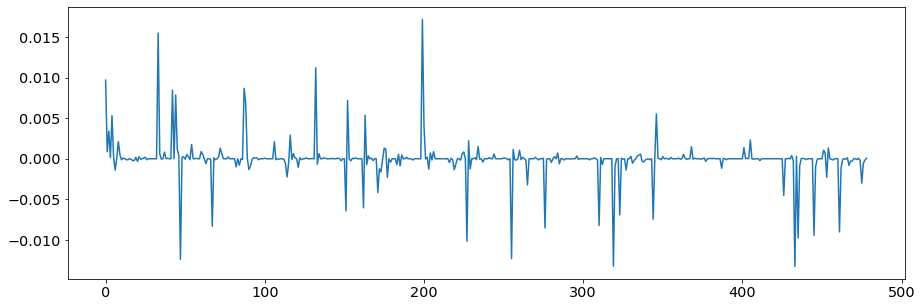

In [62]:
#regress the increments of price on the increments of OF
slope, intercept, r_value, p_value, std_err = stats.linregress(OF_inc,microprice_inc)
print(slope)
print(intercept)
print(p_value)
print(r_value**2)
res = [microprice_inc[i] - slope*OF_inc[i] - intercept for i in range(len(price_inc))]
plt.plot(res)

In [70]:
print(len(microprice_inc))
print(len(OF_inc))
print(t1)

4799
4799
[1800.1 1800.2 1800.3 ... 2279.8 2279.9 2280. ]


Text(0, 0.5, 'Microprice')

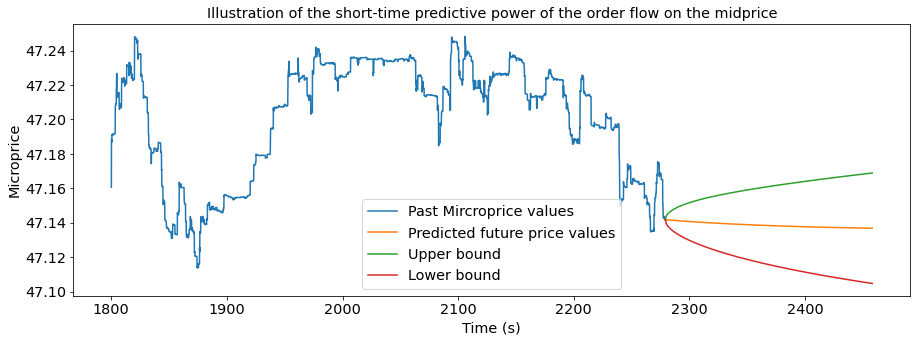

In [82]:
N = 60*10
# Past Microprice values
h = range(60*3)
plt.plot(t1,microprice_idx,label='Past Mircroprice values')

# Predictions
tab_pred = [microprice_idx[-1] - (OF2_centered[-1]*(1-phi[0]**h[i]))*slope + intercept for i in range(len(h))]
plt.plot([h[i]+t2[-1] for i in range(len(h))],tab_pred,label='Predicted future price values')


sigma_hat = np.std(res)
upper_bd = [tab_pred[i] + (h[i]**0.5)*sigma_hat for i in range(len(h))]
plt.plot([h[i]+t2[-1] for i in range(len(h))],upper_bd,label='Upper bound')
lower_bd = [tab_pred[i] - (h[i]**0.5)*sigma_hat for i in range(len(h))]
plt.plot([h[i]+t2[-1] for i in range(len(h))],lower_bd, label='Lower bound')

plt.legend(loc="lower center")
plt.title('Illustration of the short-time predictive power of the order flow on the midprice')
plt.xlabel('Time (s)')
plt.ylabel('Microprice')